We revisit chap 2 of our notebooks where we try to convert preiously built single label classifier into a multi lable one where it can also predict whether the picture has a cat in it or not 
(giving low probabilites for each class!)

In [1]:
#!fcd -c ALL -k -s 224 -m 200 -o cats cat.csv 
    

^C


In [1]:
from fastai.vision.widgets import *
from fastai.vision.all import *


In [2]:
classes = ['Abyssinian', 'American_Shorthair', 'Maine_Coon', 'Persian', 'Scottish_Fold', 'Sphynx', 't_Ragdoll']

In [7]:
path = Path('E:/Environments/fastai2/cats')

In [10]:
path.ls()

(#7) [Path('E:/Environments/fastai2/cats/Abyssinian'),Path('E:/Environments/fastai2/cats/American_Shorthair'),Path('E:/Environments/fastai2/cats/Maine_Coon'),Path('E:/Environments/fastai2/cats/Persian'),Path('E:/Environments/fastai2/cats/Scottish_Fold'),Path('E:/Environments/fastai2/cats/Sphynx'),Path('E:/Environments/fastai2/cats/t_Ragdoll')]

In [11]:
fns = get_image_files(path)
fns

(#1382) [Path('E:/Environments/fastai2/cats/Abyssinian/000001.jpg'),Path('E:/Environments/fastai2/cats/Abyssinian/000002.jpg'),Path('E:/Environments/fastai2/cats/Abyssinian/000003.jpg'),Path('E:/Environments/fastai2/cats/Abyssinian/000004.jpg'),Path('E:/Environments/fastai2/cats/Abyssinian/000005.jpg'),Path('E:/Environments/fastai2/cats/Abyssinian/000006.jpg'),Path('E:/Environments/fastai2/cats/Abyssinian/000007.jpg'),Path('E:/Environments/fastai2/cats/Abyssinian/000008.jpg'),Path('E:/Environments/fastai2/cats/Abyssinian/000009.jpg'),Path('E:/Environments/fastai2/cats/Abyssinian/000010.jpg')...]

In [66]:
cats = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(valid_pct=0.2, seed=42),
                get_y=Pipeline([parent_label, lambda l : [l]]),
                item_tfms=Resize(128))

In [27]:
dsets = cats.datasets(path)

In [28]:
x,y = dsets.train[0]
x,y

(PILImage mode=RGB size=299x299,
 TensorMultiCategory([0., 0., 1., 0., 0., 0., 0.]))

In [64]:
dls = cats.dataloaders(path,num_workers=0, batch_size=32)

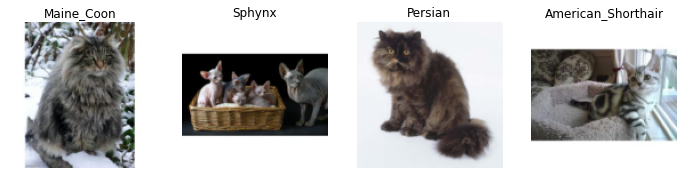

In [30]:
dls.valid.show_batch(max_n=4, nrows=1)

In [67]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders(path,num_workers = 0, batch_size=32)

In [63]:
def accuracy_multi(inp, preds,thres=0.5, sigmoid=True):
    if sigmoid : torch.sigmoid(inp)
    return ((inp>thres)==preds.bool()).float().mean()

In [68]:
learn = cnn_learner(dls, resnet34, metrics=[partial(accuracy_multi, thres=0.7)], loss_func=BCEWithLogitsLossFlat(thresh=0.6))
learn.fine_tune(4, base_lr=3e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.931667,0.649285,0.791408,00:12
1,0.738491,0.437207,0.892857,00:12
2,0.550583,0.224546,0.942547,00:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.260349,0.177125,0.951346,00:14
1,0.208169,0.140431,0.953934,00:14
2,0.159842,0.130194,0.957557,00:14
3,0.118817,0.127039,0.956004,00:14


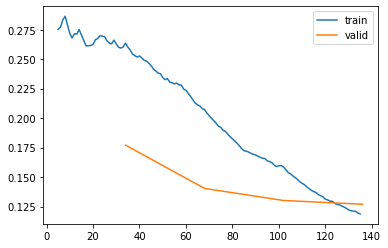

In [69]:
learn.recorder.plot_loss()

The rows represent all the cats classes in our dataset, respectively. The columns represent the images which the model predicted as different cats, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. This is one of the many ways that fastai allows you to view the results of your model. It is (of course!) calculated using the validation set. With the color-coding, the goal is to have white everywhere except the diagonal, where we want dark blue.

,target,predicted,probabilities,loss
0,American_Shorthair,Persian;Scottish_Fold,"tensor([0.0623, 0.1058, 0.0374, 0.9995, 0.6009, 0.0618, 0.0256])",1.568049669265747
1,American_Shorthair,t_Ragdoll,"tensor([0.0196, 0.0510, 0.0341, 0.0193, 0.0695, 0.0387, 0.9991])",1.4558390378952026
2,American_Shorthair,t_Ragdoll,"tensor([0.0113, 0.0459, 0.0253, 0.0962, 0.0196, 0.0360, 0.9983])",1.3816479444503784
3,Sphynx,Abyssinian,"tensor([0.9989, 0.0830, 0.0451, 0.0299, 0.0703, 0.0929, 0.0211])",1.3526445627212524
4,Abyssinian,t_Ragdoll,"tensor([0.0318, 0.1015, 0.0181, 0.0858, 0.0720, 0.2779, 0.9760])",1.1134238243103027
5,American_Shorthair,Sphynx,"tensor([0.3008, 0.0645, 0.0260, 0.0078, 0.0483, 0.9843, 0.0819])",1.0606498718261719
6,Abyssinian,t_Ragdoll,"tensor([0.0334, 0.0683, 0.0616, 0.0364, 0.0443, 0.0536, 0.9672])",1.0128834247589111
7,Persian,Maine_Coon,"tensor([0.0685, 0.1355, 0.9844, 0.3002, 0.0086, 0.0163, 0.2491])",0.8417410254478455
8,Maine_Coon,American_Shorthair,"tensor([0.3710, 0.6494, 0.0484, 0.0766, 0.2246, 0.1333, 0.2823])",0.7641506791114807
9,American_Shorthair,Maine_Coon,"tensor([0.0408, 0.1945, 0.9532, 0.1689, 0.0146, 0.0125, 0.0913])",0.7212859988212585


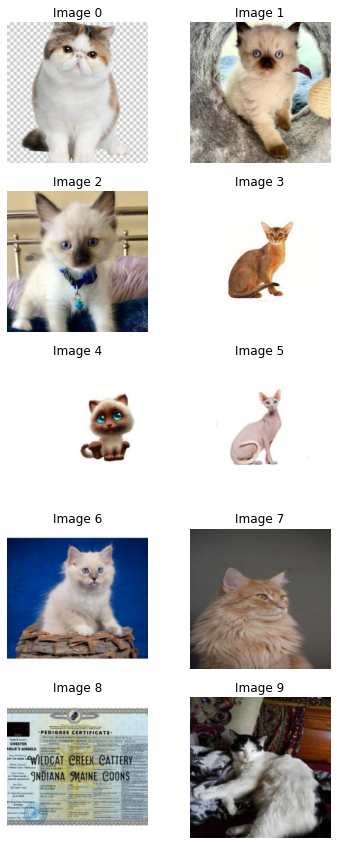

In [47]:
interp.plot_top_losses(10, nrows=5)

In [42]:
dls.vocab

(#7) ['Abyssinian','American_Shorthair','Maine_Coon','Persian','Scottish_Fold','Sphynx','t_Ragdoll']

In [48]:
learn.metrics = partial(accuracy_multi, thres = 0.99)
learn.validate()

(#2) [0.17339587211608887,0.9560041427612305]

In [61]:
learn.metrics = partial(accuracy_multi, thres = 0.7)
learn.validate()

(#2) [0.17339587211608887,0.9591097831726074]

In [50]:
x,y = learn.get_preds()

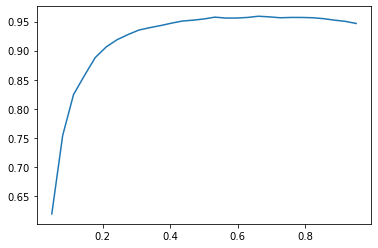

In [60]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(x, y, thres=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [14]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

When we use a model for getting predictions, instead of training, we call it inference. To create our inference learner from the exported file, we use load_learner (in this case, this isn't really necessary, since we already have a working Learner in our notebook; we're just doing it here so you can see the whole process end-to-end

In [15]:
learn.dls.vocab

(#7) ['Abyssinian','American_Shorthair','Maine_Coon','Persian','Scottish_Fold','Sphynx','t_Ragdoll']

In [16]:
learn.predict('cats/Persian/000001.jpg')

('Persian',
 tensor(3),
 tensor([1.5475e-06, 4.5805e-07, 2.4767e-03, 9.9148e-01, 5.9164e-03, 5.9453e-06,
         1.1717e-04]))

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the vocab of the DataLoaders; that is, the stored list of all possible categories. At inference time, you can access the DataLoaders as an attribute of the Learner

# Creating a Notebook App from the Model

In [70]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [72]:
img = PILImage.create(btn_upload.data[-1])

In [73]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [76]:
pred,pred_idx,probs = learn.predict(img)
pred,pred_idx,probs

((#1) ['Sphynx'],
 tensor([False, False, False, False, False,  True, False]),
 tensor([1.6863e-04, 3.0247e-03, 2.5259e-04, 3.8749e-03, 7.7582e-03, 1.0000e+00,
         1.9630e-03]))

In [92]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction:{pred}, Probabilities = {np.around(probs,4)},Pred_idx = {np.where(pred_idx)[0]}'
lbl_pred

Label(value="Prediction:(#1) ['Sphynx'], Probabilities = tensor([2.0000e-04, 3.0000e-03, 3.0000e-04, 3.9000e-0…

In [78]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [94]:
def classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f'Prediction:{pred}, Probabilities = {np.around(probs,4)},Pred_idx = {np.where(pred_idx)[0]}'

btn_run.on_click(classify)

In [95]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [96]:
VBox([widgets.Label('Select your CAt!'), 
      btn_upload, btn_run,out_pl, lbl_pred])